# Causal Effect Inference

We are in the context of an **observational study**: we observe outcomes ($y$) for available subjects (with characteristics $x$) on the variables of interest ($t$) without control over this variable. This setting poses a problem: there may be lurking variables not taken into account who affect both the treatment and the outcome (i.e., confounders) making the establishment of cause and effect much harder.

This stands in contrast to Randomized Clinical Trials (RCTs), where instead we can randomize the assignment of the subjects to the values of the variable of interest so that no confounders are present.

In [1]:
from data_gen import synthetic_dataset_pyro
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np

In [30]:
data = synthetic_dataset_pyro(n=2000, beta=2.0, num_proxies=10,prior_type = "gaussian", seed=42)
data.keys()

dict_keys(['x', 't', 'y', 'z', 'ite'])

In [ ]:
# translating the dictionary in a dataframe
# I need to change the x matrix in different x columns
for i in range(data["x"].shape[1]):
    data["x_"+str(i)] = data["x"][:,i]

data.pop("x",None)

data_df = pd.DataFrame.from_dict(data)
data_df.head()

,t,y,z,ite,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,1.0,3.374198,1.926915,1.963458,-0.688857,-1.794350,0.164417,-1.106328,0.477889,-0.949815,-1.100642,-0.573700,1.335683,-0.812672
1,0.0,0.389723,1.487284,1.743642,-0.803419,-0.667056,-0.221031,-0.335255,-2.074355,-0.946630,-0.484487,0.730178,-0.984199,0.626180
2,1.0,2.342756,0.900717,1.450359,-0.960594,0.498550,-0.208753,0.067716,0.217839,-0.090666,0.945358,0.879692,-1.900329,-1.909228
3,0.0,-3.112403,-2.105521,-0.052760,0.131827,1.523604,-1.069372,0.534380,-0.513794,2.163477,0.522745,-2.856230,-0.540974,0.486115
4,1.0,2.221629,0.678418,1.339209,0.114251,-1.388160,-0.912516,0.000940,1.237285,-0.903159,-1.597616,-1.240581,0.409051,-0.279541


In [18]:
model = CausalModel(data_df, treatment="t", outcome="y", common_causes=["x_"+str(i) for  i in range(0,10)])

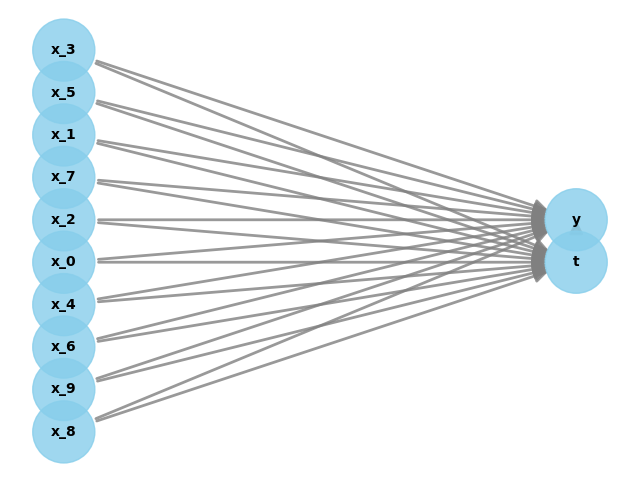

In [20]:
model.view_model()

In [27]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_8,x_9,x_6,x_4,x_0,x_2,x_7,x_1,x_5,x_3])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_8,x_9,x_6,x_4,x_0,x_2,x_7,x_1,x_5,x_3,U) = P(y|t,x_8,x_9,x_6,x_4,x_0,x_2,x_7,x_1,x_5,x_3)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [28]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)

print("Causal Estimate is " + str(estimate.value))
data_1 = data_df[data_df["t"]==1.0]
data_0 = data_df[data_df["t"]==0.0]

print("ATE", np.mean(data_1["y"])- np.mean(data_0["y"]))


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_8,x_9,x_6,x_4,x_0,x_2,x_7,x_1,x_5,x_3])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_8,x_9,x_6,x_4,x_0,x_2,x_7,x_1,x_5,x_3,U) = P(y|t,x_8,x_9,x_6,x_4,x_0,x_2,x_7,x_1,x_5,x_3)

## Realized estimand
b: y~t+x_8+x_9+x_6+x_4+x_0+x_2+x_7+x_1+x_5+x_3
Target units: ate

## Estimate
Mean value: 1.8260613793848979
p-value: [7.30073992e-131]

Causal Estimate is 1.8260613793848979
ATE 2.6441078


c:\Users\desta\OneDrive - Università degli Studi di Trieste\Desktop\Deep Learning\venv\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
